# 量子线路仿真

In [1]:
# Import necessary data-processing modules
import numpy as np
import pandas as pd

# Control matplotlib style (white background)
%matplotlib inline
from matplotlib import style
from IPython.display import display
style.use('seaborn-white')

# Import QisKit
import qiskit
import qiskit.tools.jupyter
%qiskit_version_table

# function to inspect given quantum circuit
def inspect_quantum_circuit(c):
    if type(c) is not qiskit.circuit.quantumcircuit.QuantumCircuit:
        print('The input is not Quantum Circuit defined in QisKit')
        return
    print('Inspect Quantum Circuit {}'.format(c.name)) # display name
    print()
    if c.num_qubits > 0:
        print('There are {} qubits in {} quantum regiters'.format(c.num_qubits, len(c.qregs)))
        for reg in c.qregs:
            print('  {}'.format(reg)) # display every quantum regiter
    else:
        print('There is no qubit')
    print()
    if c.num_clbits > 0:
        print('There are {} classic bits in {} classic registers'.format(c.num_clbits, len(c.cregs)))
        for reg in c.cregs:
            print('  {}'.format(reg)) # display every classic register
    else:
        print('There is no classic bit')
    print()
    if len(c.data) > 0:
        print('There are {} instructions'.format(len(c.data)))
        for inst in c.data:
            print('  {}'.format(inst)) # display every instruction
    else:
        print('There is no instruction')
    print()
    print('Image of circuit:') # display circuit image
    display(c.draw())
    print()

# function to compose several quantum circuits
def compose_circuits(circuits):
    circ = qiskit.QuantumCircuit()
    is_head = True
    for c in circuits:
        if type(c) is not qiskit.circuit.quantumcircuit.QuantumCircuit:
            continue
        if c.num_qubits > circ.num_qubits:
            circ.add_register(qiskit.QuantumRegister(c.num_qubits - circ.num_qubits))
        if c.num_clbits > circ.num_clbits:
            circ.add_register(qiskit.ClassicalRegister(c.num_clbits - circ.num_clbits))
        if is_head:
            is_head = False
        else:
            #print('add barrier before {}'.format(c.name))
            circ.barrier()
        #print('compose {}'.format(c.name))
        circ.compose(c, inplace = True)
    return circ

## 概述

在不连接IBM量子计算机情况下，QisKit提供三种量子线路的仿真后端：

1. 状态向量，用于分析纯量子比特线路的状态空间；
2. 幺正算子，用于分析纯量子比特线路对应的幺正孙子；
3. 计算模拟，用于模拟具有测量输出的量子线路运算结果。

这三个后端都可以通过Aer模块的`get_backend`函数获取，对应的名称分别为“statevector_simulator”、“unitary_simulator”和“qasm_simulator”。

## 准备线路

下面准备一个纯量子比特线路`circ_q`，再准备一个包含测量的量子比特线路`circ`，用于测试3种仿真后端。

Inspect Quantum Circuit qc_pure

There are 4 qubits in 1 quantum regiters
  QuantumRegister(4, 'q')

There is no classic bit

There are 5 instructions
  (Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(4, 'q'), 0)], [])
  (Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(4, 'q'), 1)], [])
  (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), [Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2)], [])
  (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), [Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 2)], [])
  (Instruction(name='ccx', num_qubits=3, num_clbits=0, params=[]), [Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 3)], [])

Image of circuit:


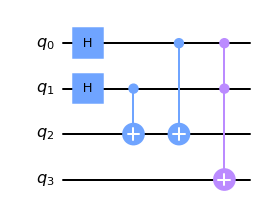

In [2]:
circ_q = qiskit.QuantumCircuit(4, name='qc_pure')
circ_q.h(0)
circ_q.h(1)
circ_q.cx(1, 2)
circ_q.cx(0, 2)
circ_q.ccx(0, 1, 3)

inspect_quantum_circuit(circ_q)

Inspect Quantum Circuit qc_with_measure

There are 4 qubits in 1 quantum regiters
  QuantumRegister(4, 'q')

There are 2 classic bits in 1 classic registers
  ClassicalRegister(2, 'c')

There are 7 instructions
  (Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(4, 'q'), 0)], [])
  (Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(4, 'q'), 1)], [])
  (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), [Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2)], [])
  (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), [Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 2)], [])
  (Instruction(name='ccx', num_qubits=3, num_clbits=0, params=[]), [Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 3)], [])
  (Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), [Qubit(QuantumRegister(4, 'q'), 2)], [Clbit(

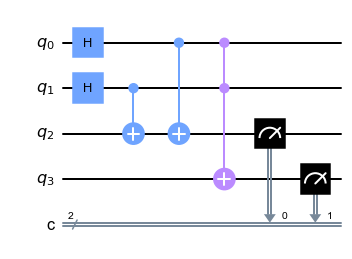

In [3]:
circ = circ_q.copy()
circ.name = 'qc_with_measure'
circ.add_register(qiskit.ClassicalRegister(2, 'c'))
circ.measure([2, 3], [0, 1])

inspect_quantum_circuit(circ)

## 状态向量

使用状态向量后端运行纯量子比特线路，所得结果中数据为线路对应的状态向量。

In [4]:
backend_statevector = qiskit.Aer.get_backend('statevector_simulator')
job0 = backend_statevector.run(circ_q)
result0 = job0.result()
print(result0.data())

{'statevector': Statevector([ 0.5+0.j,  0. +0.j, -0. +0.j, -0. +0.j,  0. +0.j,  0.5+0.j,
              0.5+0.j, -0. +0.j,  0. +0.j,  0. +0.j, -0. +0.j,  0.5+0.j,
              0. +0.j,  0. +0.j, -0. +0.j, -0. +0.j],
            dims=(2, 2, 2, 2))}


可以通过`get_statevector`函数获取状态向量，使用“latex”风格绘制状态向量，可以得到向量对应的解析式。

In [5]:
state_vector = result0.get_statevector()
state_vector.draw('latex')

<IPython.core.display.Latex object>

## 幺正算子

幺正算子是量子线路在数学上的等价算符，使用该后端进行仿真，所得结果中数据为线路对应幺正算子。

In [6]:
backend_unitary = qiskit.Aer.get_backend('unitary_simulator')
job1 = backend_unitary.run(circ_q)
result1 = job1.result()
print(result1.data())

{'unitary': Operator([[ 0.5+0.0000000e+00j,  0.5-6.1232340e-17j,  0.5-6.1232340e-17j,
            0.5-1.2246468e-16j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j],
          [ 0. +0.0000000e+00j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j,  0.5+0.0000000e+00j, -0.5+6.1232340e-17j,
            0.5-6.1232340e-17j, -0.5+1.2246468e-16j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j],
          [-0. +0.0000000e+00j, -0. +0.0000000e+00j, -0. +0.0000000e+00j,
           -0. +0.0000000e+00j,  0.5+0.0000000e+00j,  0.5-6.1232340e-17j,
           -0.5+6.1232340e-17j, -0

使用`get_unitary`函数从结果中获取幺正算子

In [7]:
unitary = result1.get_unitary()
print(unitary)

Operator([[ 0.5+0.0000000e+00j,  0.5-6.1232340e-17j,  0.5-6.1232340e-17j,
            0.5-1.2246468e-16j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j],
          [ 0. +0.0000000e+00j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j,  0.5+0.0000000e+00j, -0.5+6.1232340e-17j,
            0.5-6.1232340e-17j, -0.5+1.2246468e-16j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j],
          [-0. +0.0000000e+00j, -0. +0.0000000e+00j, -0. +0.0000000e+00j,
           -0. +0.0000000e+00j,  0.5+0.0000000e+00j,  0.5-6.1232340e-17j,
           -0.5+6.1232340e-17j, -0.5+1.2246468

## 计算模拟

计算模拟器针对具有测量输出的量子线路，仿真其在真实量子芯片上运算的结果，是离线状态模拟量子算法的重要工具。使用计算模拟器，与上面的两个分析型后端主要有3点区别：

1. 线路必须包含测量输出；
2. QisKit中的计算模拟器针对OpenQasm量子汇编设计，因此，在使用该后端运行线路时，需要先将线路转换为OpenQasm汇编；
3. 一般在`run`函数中要指定模拟的次数。

计算模拟后端运行的结果为不同输出值出现的次数。

In [8]:
backend_qasm = qiskit.Aer.get_backend('qasm_simulator')
job2 = backend_qasm.run(qiskit.transpile(circ, backend_qasm), shots=1024)
result2 = job2.result()
print(result2.data())

{'counts': {'0x1': 513, '0x0': 256, '0x2': 255}}


使用`get_counts`函数从结果中获取模拟结果，结果可以使用柱状图进行可视化。

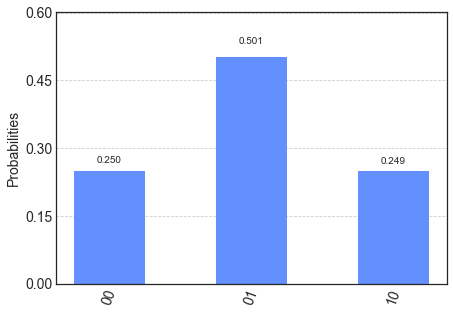

In [9]:
counts = result2.get_counts()
qiskit.visualization.plot_histogram(counts)

## 集成

针对任意可以简单拆分为纯量子比特线路和纯测量线路的量子线路，这里定义一个集成的仿真函数，利用3种后端获取线路对应的状态向量、幺正算子和计算模拟结果。

In [10]:
# synchronized simulation for simple two-parts quantum circuits
def qiskit_syn_simulate(circ_q, circ_m, shots = 1024):
    if type(circ_q) is not qiskit.circuit.quantumcircuit.QuantumCircuit or circ_q.num_clbits > 0:
        print('Pure quantum circuit is invalid')
        return None, None, None
    if type(circ_m) is not qiskit.circuit.quantumcircuit.QuantumCircuit or circ_m.num_clbits == 0:
        print('Measure circuit is invalid')
        return None, None, None
    if shots < 1:
        print('Simulation shots must be positive')
        return None, None, None
    circ = compose_circuits([circ_q, circ_m]) # get combined circuit
    results = [] # prepare results
    backends = [
        ('statevector_simulator', lambda backend : backend.run(circ_q).result().get_statevector()),
        ('unitary_simulator', lambda backend : backend.run(circ_q).result().get_unitary()),
        ('qasm_simulator', lambda backend : backend.run(qiskit.transpile(circ, backend), shots = shots).result().get_counts())
    ]
    for name, opt in backends:
        backend = qiskit.Aer.get_backend(name)
        results.append(opt(backend))
    return tuple(results)

Inspect Quantum Circuit circuit-144

There are 4 qubits in 1 quantum regiters
  QuantumRegister(4, 'q')

There are 2 classic bits in 1 classic registers
  ClassicalRegister(2, 'c')

There are 2 instructions
  (Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), [Qubit(QuantumRegister(4, 'q'), 2)], [Clbit(ClassicalRegister(2, 'c'), 0)])
  (Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), [Qubit(QuantumRegister(4, 'q'), 3)], [Clbit(ClassicalRegister(2, 'c'), 1)])

Image of circuit:


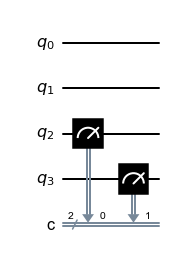

In [11]:
# generate circuit to measure last two qubits
circ_m = qiskit.QuantumCircuit(4, 2)
circ_m.measure([2, 3], [0, 1])
inspect_quantum_circuit(circ_m)

<IPython.core.display.Latex object>

Operator([[ 0.5+0.0000000e+00j,  0.5-6.1232340e-17j,  0.5-6.1232340e-17j,
            0.5-1.2246468e-16j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j],
          [ 0. +0.0000000e+00j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j,  0.5+0.0000000e+00j, -0.5+6.1232340e-17j,
            0.5-6.1232340e-17j, -0.5+1.2246468e-16j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j,  0. +0.0000000e+00j,  0. +0.0000000e+00j,
            0. +0.0000000e+00j],
          [-0. +0.0000000e+00j, -0. +0.0000000e+00j, -0. +0.0000000e+00j,
           -0. +0.0000000e+00j,  0.5+0.0000000e+00j,  0.5-6.1232340e-17j,
           -0.5+6.1232340e-17j, -0.5+1.2246468

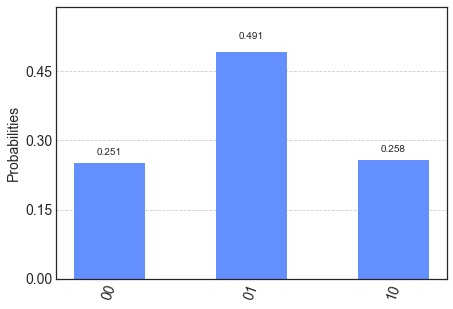

In [12]:
state_vector, unitary, counts = qiskit_syn_simulate(circ_q, circ_m)
display(state_vector.draw('latex'))
print(unitary)
display(qiskit.visualization.plot_histogram(counts))